# Algotrading

A pet project aimed at predicting a cryptocurrency price based on data from polymarket.com

## Problem definition


**Meta**: Try to make minimal possible solution & move to more complex ones if a simple one does not perform as we wish it to.

**A goal** is to check whether there is a correlation between crypto currencies (CC) price in the future with & polymarket polls about them.


## Available datapoints are


- CC price from Binance (target)

**Polymarket has polls of varying types**, but at its core, there is a single (Yes/No) bet. Polls of choice type are just an ordered list of (Yes/No) polls.

Some of the polls formats:
- (Choice) Price range prediction of CC at a time point
- (Choice) Min price pred. at a time point
- (Choice) When will a CC reach an all time high
- (Yes/No) Will a CC reach an all time high before some time point
- (Yes/No) Will a CC be above some price at a time point?
- etc.


**Each poll has these datapoints**:
- Total volume in USD
- End date
- For each option to make a bet on, there is a "chance" of it happening, computed using bets distribution.
- How "chance" of an event was changing over time (a graph, chart)
- Price for 100 shares. When placing a bet, user is buying shares. In the UI price per 100 shares is shown. Price of a single share varies between 0 and 1. When a bet is resolved and user made a winning bet, every share is exchanged to 1.
- Distribution of how much shares were purchased at what price for each betting option
- Comments on a poll. They can also be replies to top-level comments.
	- Content, text
	- Amount of likes
	- Shares he has on a poll. Note: multiple bets can be placed on a single poll. Total shares amount he has & for which option is shown. It means it is not shown how much money he spent, as share price has a varying price.
- 15 top holders of each option
- Recent activity: who purchased or sold shares and at what cost
- A list of related polls. Potentially, we could extract data from these polls too. For example, for a poll "Bitcoin above 105,000 on January 31?" its related bet can be "Will Bitcoin reach 110_000 by January 31, 2025"

**We can view top users** by their betting volume & profit. **Their bets could be mimiced**.
Looks like a bot to me: https://polymarket.com/profile/0x42a6ddf7cf7032972b0bfe32775e8109c5171b64?tab=activity


## Visual analysis


I've placed 2 charts side my side: BCT Price and Polymarket confidence in BTC hitting a price of 120k by March 31. Visually it can be seen that Polymarket roughly mimics the BTC price trend, which had never reached this price point, typically being in a range of 95k-105k.

Notably, other polymerket polls - 110k, 130k, 150k, 200k have a similar shape, where bigger the poll price (200k), less similar (mimicing its up's and down's) it is to a BTC price at that time.

Binance BTC Price Chart            |  Market confidence in "BTC will hit 120k by March 31" 
:-------------------------:|:-------------------------:
![image.png](../static/1_binance_btc_chart.png)  |  ![image.png](../static/1_polymarket_BTC_hit_120k.png)


Next observation is, that polls that bet on a lower outcome than the current price have a negative correlation, meaning that when more people bet "Yes" on 120k, more people vote "No" on 80k.

Market confidence in "BTC will hit 120k by March 31"
![image.png](../static/1_polymarket_BTC_hit_120k.png)  

Market confidence in "BTC will hit 80k by March 31"
![image.png](../static/1_polymarket_BTC_hit_80k.png)


## Short-term correlation of BTC price and polymarket polls

I have attempted to make a correlation between polymarket probabilities and BTC price changes. Below it is shown that they indeed are correlated.

In [55]:
import importlib
from datetime import datetime

import numpy as np

import poly_datasets
import poly_api
import binance_datasets
import analysis

In [41]:
def analyze_poly_markets(
    markets: list[poly_datasets.PMDataset],
    fidelity: int,
    corr_offset_amplitude: int,
    strip_percent: int | None = None,
    min_corr_threshold: float = 0.0,
):
    print(f"Analyzing {len(markets)} markets")

    # Remove first and last X% of datapoints for more stability.
    # At the start probability is 0.5
    #   -> TODO: Is it useful?
    # At the end people are much more confitend because time is up
    #   -> probability is around 0 or 1
    #   -> TODO: Is it useful?
    stripped_markets: list[poly_datasets.PMDataset] = []
    if strip_percent is not None:
        for market in markets:
            start_idx = len(market.index) // strip_percent
            end_idx = (len(market.index) -1) - start_idx

            stripped_markets.append(
                market.subset(
                    market.index[start_idx],
                    market.index[end_idx],
                )
            )
    else:
        stripped_markets = markets

    # Remove markets with insufficient data
    filtered_markets: list[poly_datasets.PMDataset] = []
    for idx in range(len(markets)):
        market = stripped_markets[idx]
        if len(market.open) < corr_offset_amplitude * 2:
            print(f"Skipping `{market.label}` due to insufficient data")
            continue

        filtered_markets.append(market)

    binance_df = binance_datasets.load_matching_binance_data(filtered_markets, fidelity)
    binance_deltas = [
        binance_df.loc[market.index, "delta"] for market in filtered_markets
    ]

    # Compute correlations with offset
    corr_coef = analysis.compute_delta_correlation(
        filtered_markets, binance_deltas, corr_offset_amplitude
    )

    # Get rid of weakly correlated markets
    end_corr_coef = []
    end_markets = []

    for idx, corr in enumerate(corr_coef):
        market = filtered_markets[idx]
        if np.max(np.abs(corr)) <= min_corr_threshold:
            print(
                f"Skipping `{market.label}` due to low correlation (corr < {min_corr_threshold})"
            )
            continue

        end_corr_coef.append(corr)
        end_markets.append(market)

    print(f"Plotting {len(end_markets)} markets")

    analysis.plot_delta_correlation(
        end_markets, binance_df, end_corr_coef, corr_offset_amplitude
    )

Analyzing 14 markets
Loading from binance at intervals: from 2025-01-02 20:00:00 until 2025-01-30 21:00:00
Skipping `will-bitcoin-reach-200000-by-january-31-2025` due to low correlation (corr < 0.3)
Skipping `will-bitcoin-reach-150000-by-january-31-2025` due to low correlation (corr < 0.3)
Skipping `will-bitcoin-dip-to-70000-by-january-31-2025` due to low correlation (corr < 0.3)
Skipping `will-bitcoin-dip-to-60000-by-january-31-2025` due to low correlation (corr < 0.3)
Skipping `will-bitcoin-dip-to-50000-by-january-31-2025` due to low correlation (corr < 0.3)
Plotting 9 markets


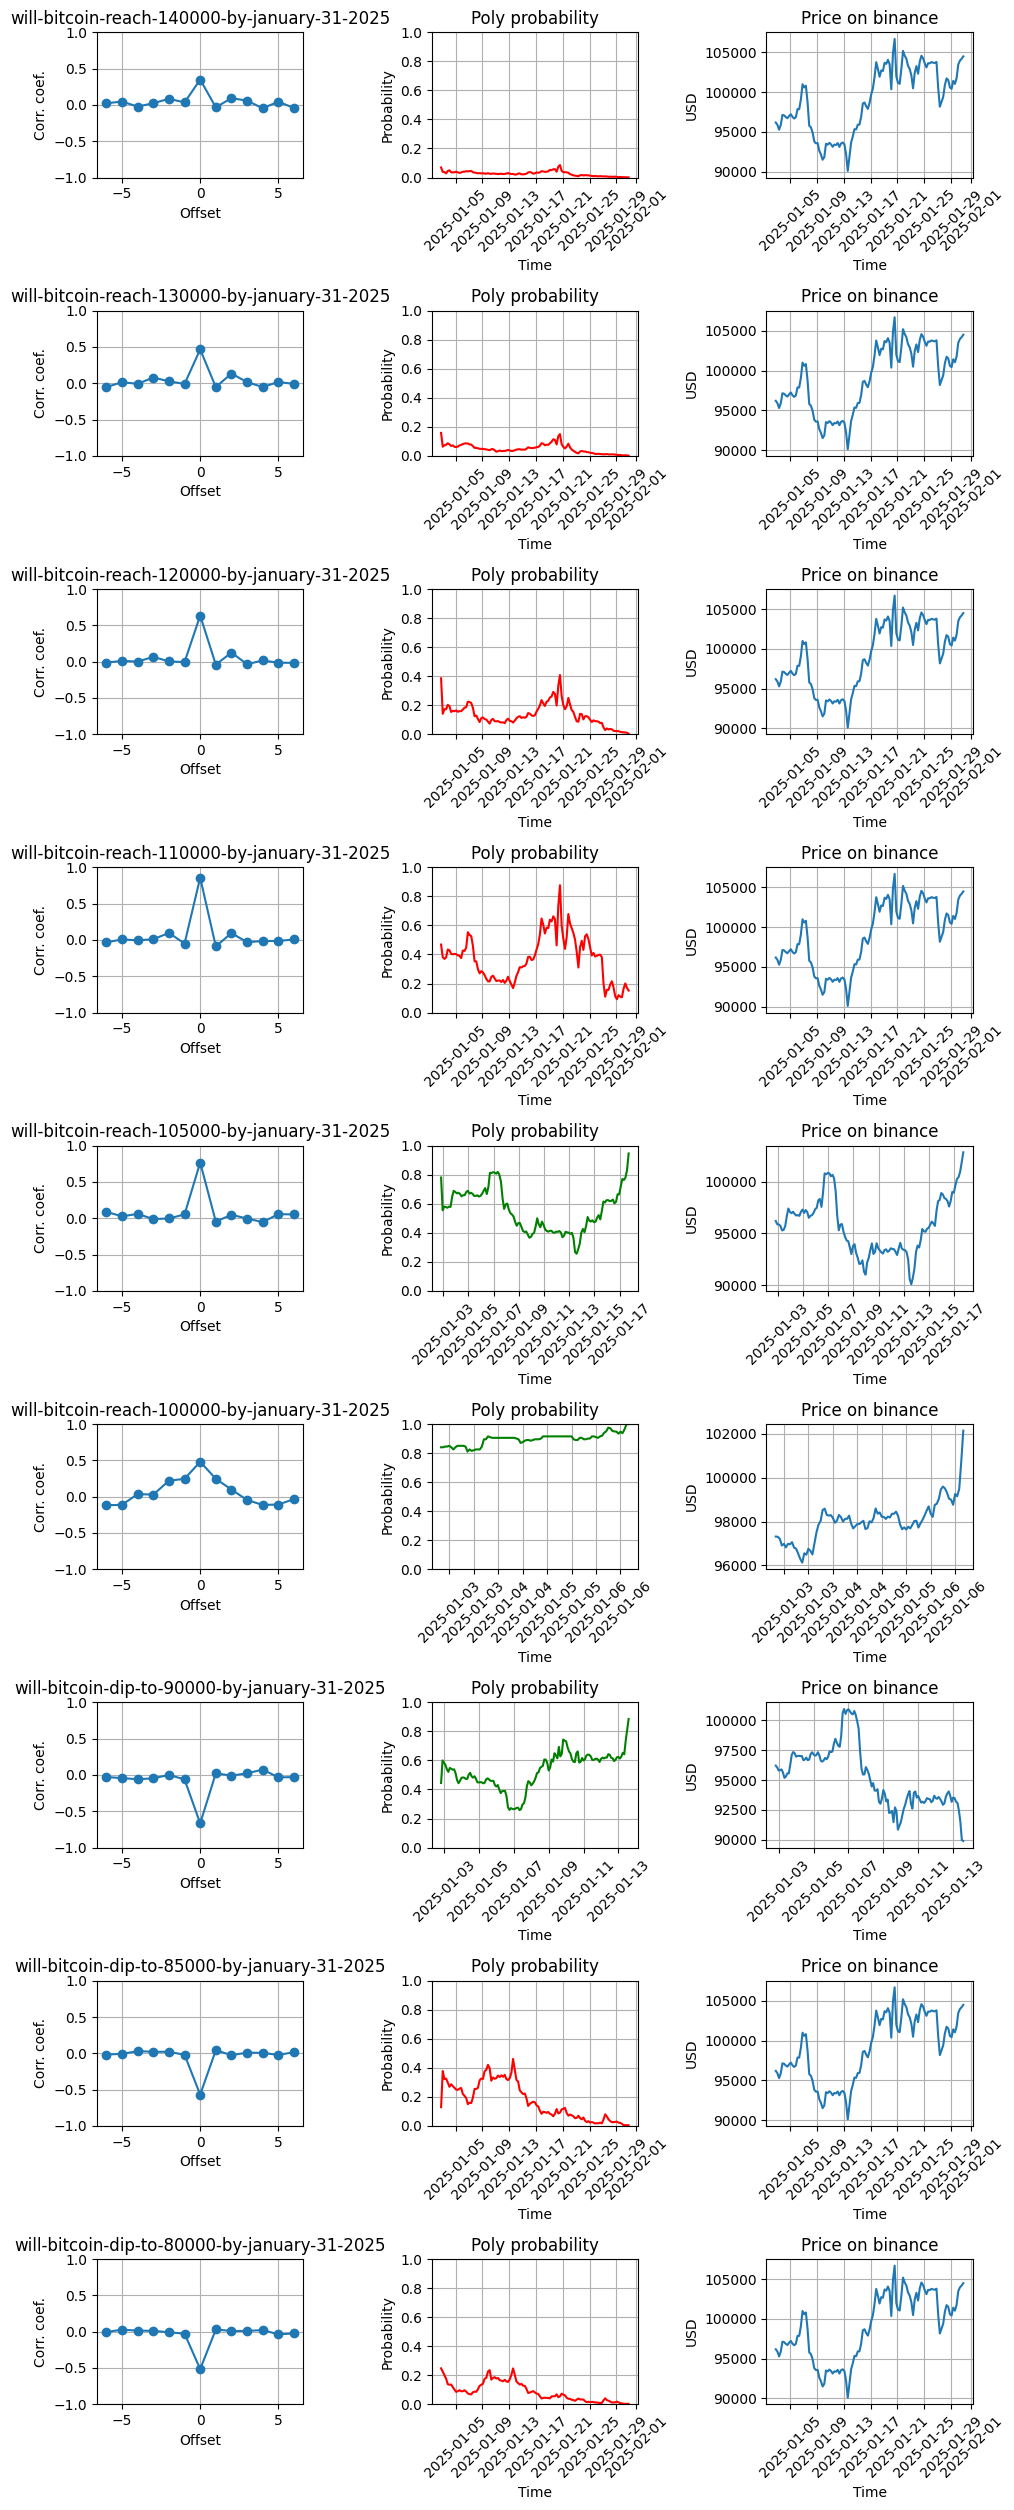

In [ ]:
# importlib.reload(analysis)

# Same markets as in 2_pm_BTC_1(d|h).csv
# https://polymarket.com/event/what-price-will-bitcoin-hit-in-january?tid=1742039982785
# To find these IDs, I have opened the network tab in the browser
# and looked for the request to the `/trades` endpoint.
# The IDs are in the `market` query parameter.
market_ids = [
    "0xc2c1038424a37a044781d1915e82ddbea1515d79cdb8966a2bf0a658b178b21c",
    "0x69c7ea583787dee4228468864414f33c84c3ab58c2eaba37ca7a5c0aed4e899e",
    "0xd7fa09afd9c184f94edb6f15f5f98640dc3f5418ffbd520a10ef3f4775414c73",
    "0x78dd44195111f89210b059180792a1fa156d1f211392e76575dc36846e815987",
    "0x7c662197ecf9c6c2441c1cb57e8c8a761a5782eeb0c219dc14daf3f165d188a1",
    "0x0f3131c874579825ecdbbda8c7aeed071aa908d7c993792c393285900e68906f",
    "0x44c5b4d851e8c06698c13b54e8ba33e37637e13bdb3f375ce0b6727b2aa06b48",
    "0x0bdabf234110590a6475e88f386ec7512f0f0d8038989e39259f0eb995650594",
    "0xcdab757d22e9ca242163475ed1426e6a8d2c9a579b39198f7cec223024ee2e89",
    "0x8d29692749f246da11fb329a2ecaf95d08cc6c97d3f8ebe0c052d1ce42057595",
    "0xda728da52dda8a465dd49a1e9a6daa000b2116bd799b18ec383c68e68c693bda",
    "0x263c7f77dc9cc2a68ce238794051b4801ae0d0aa0b1242a54726a8860a1809e8",
    "0xd100eaa5eb47d06b9f3f4ff37ad34c1e588b3f322cd8d7d408c379a2ce3ea03e",
    "0x906a2b90f30c62e09dce56fababafafbc4338cb8dac94ac6c3038327d0447180",
]
# Load data with 60 minutes interval between samples
ts_options = poly_api.TSOptions(
    fidelity_in_minutes=60,
    interval_to_load=(
        datetime.fromisoformat("2025-01-02 19:00"),  # Market start date
        datetime.fromisoformat("2025-01-30 23:00"),  # Market end date
    ),
)
corr_offset_amplitude = 6
raw_markets = poly_api.load_markets_data(market_ids, ts_options)
processed_markets = poly_datasets.process_pm_df(raw_markets)


analyze_poly_markets(
    processed_markets,
    ts_options.fidelity_in_minutes,
    corr_offset_amplitude,
    strip_percent=None,
    min_corr_threshold=0.3,
)

Analyzing 14 markets
Loading from binance at intervals: from 2025-01-02 19:15:00 until 2025-01-30 21:45:00
Skipping `will-bitcoin-reach-200000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-reach-150000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-60000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-50000-by-january-31-2025` due to low correlation (corr < 0.1)
Plotting 10 markets


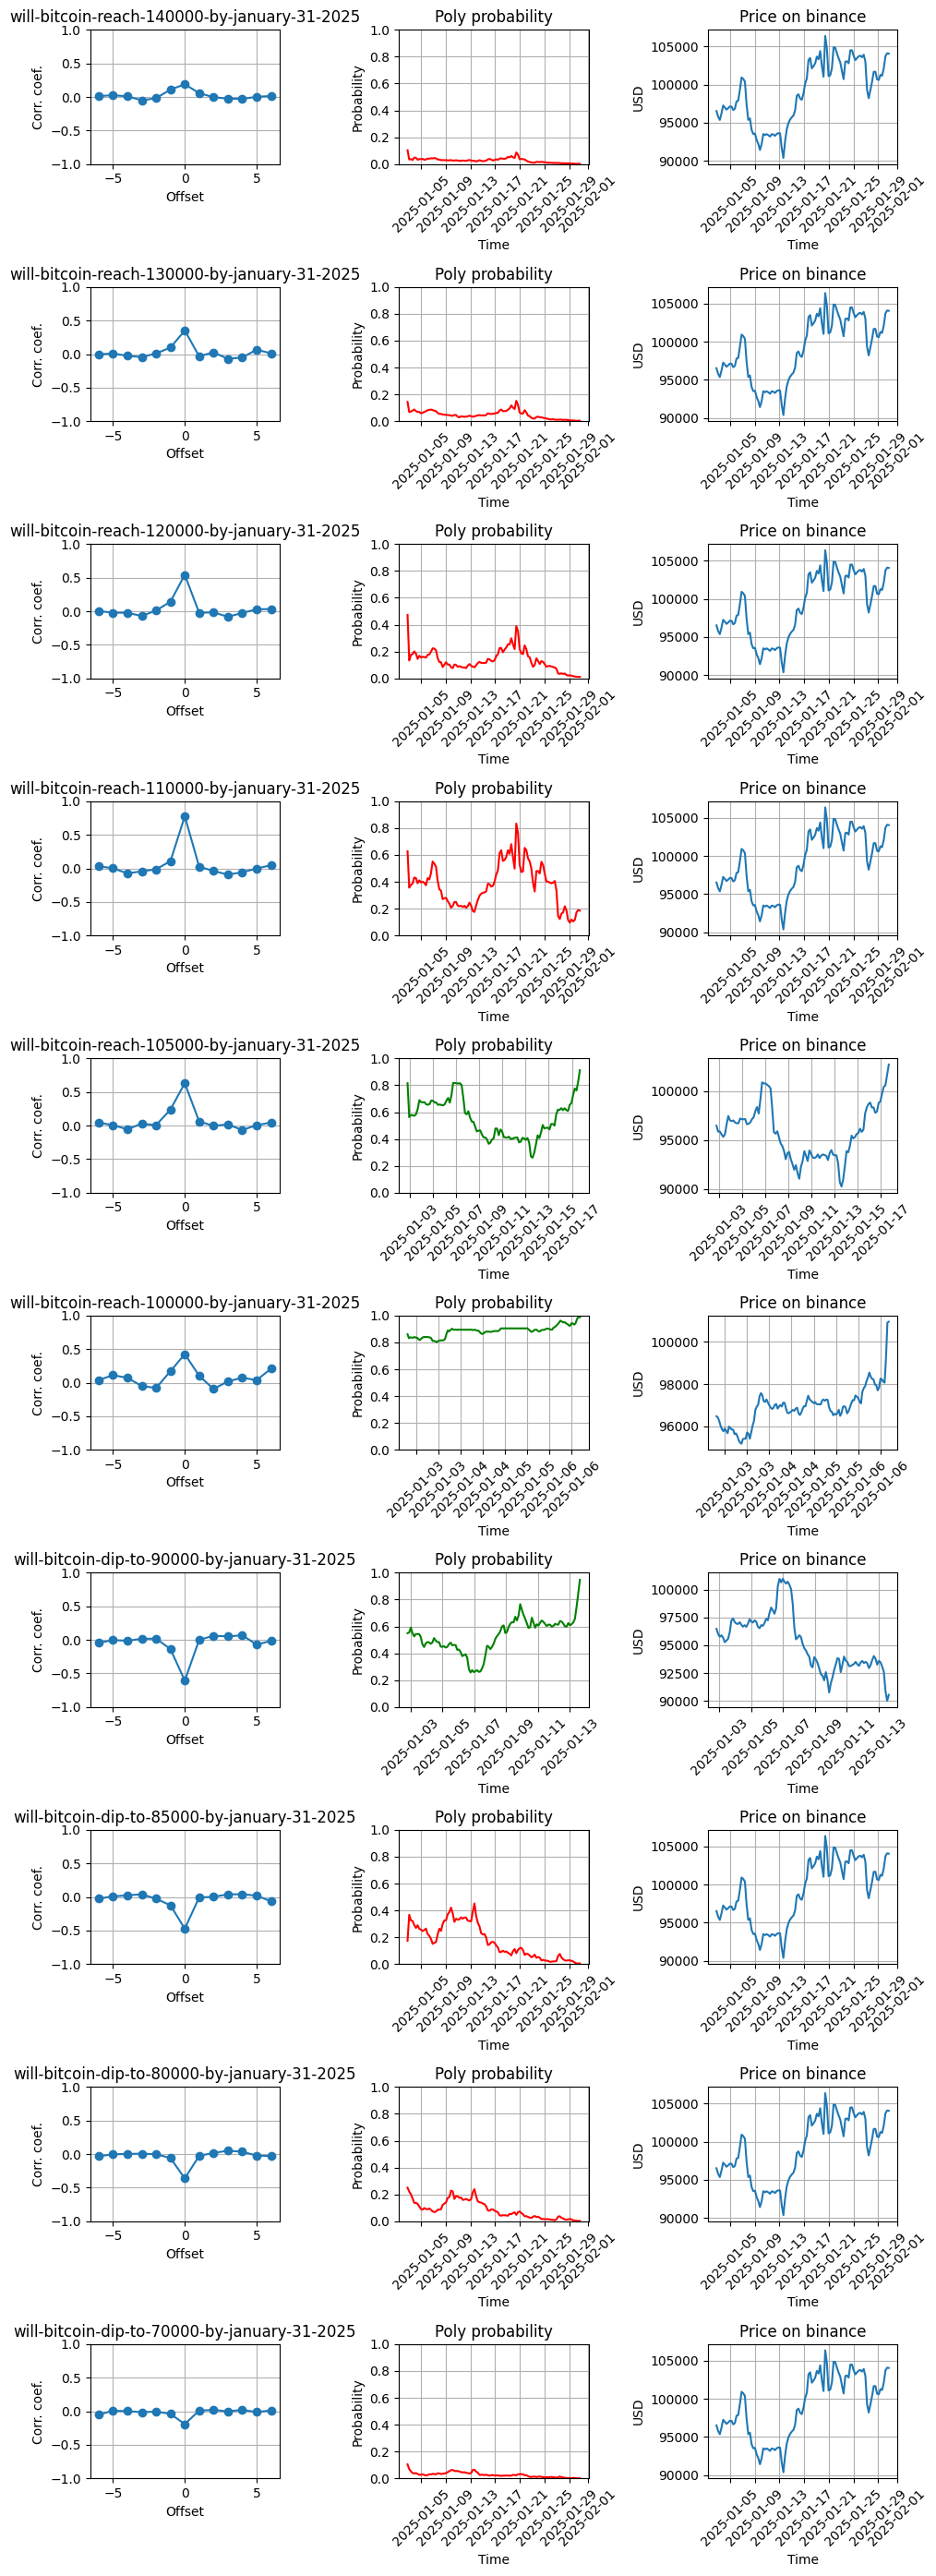

In [52]:
ts_options = poly_api.TSOptions(
    fidelity_in_minutes=15,
    interval_to_load=(
        datetime.fromisoformat("2025-01-02 19:00"),  # Market start date
        datetime.fromisoformat("2025-01-30 23:00"),  # Market end date
    ),
)
corr_offset_amplitude = 6
raw_markets = poly_api.load_markets_data(market_ids, ts_options)
processed_markets = poly_datasets.process_pm_df(raw_markets)


analyze_poly_markets(
    processed_markets,
    ts_options.fidelity_in_minutes,
    corr_offset_amplitude,
    strip_percent=None,
    min_corr_threshold=0.1,
)

Analyzing 14 markets
Loading from binance at intervals: from 2025-01-02 19:09:00 until 2025-01-30 21:57:00
Skipping `will-bitcoin-reach-200000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-reach-150000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-reach-140000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-reach-130000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-70000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-60000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-50000-by-january-31-2025` due to low correlation (corr < 0.1)
Plotting 7 markets


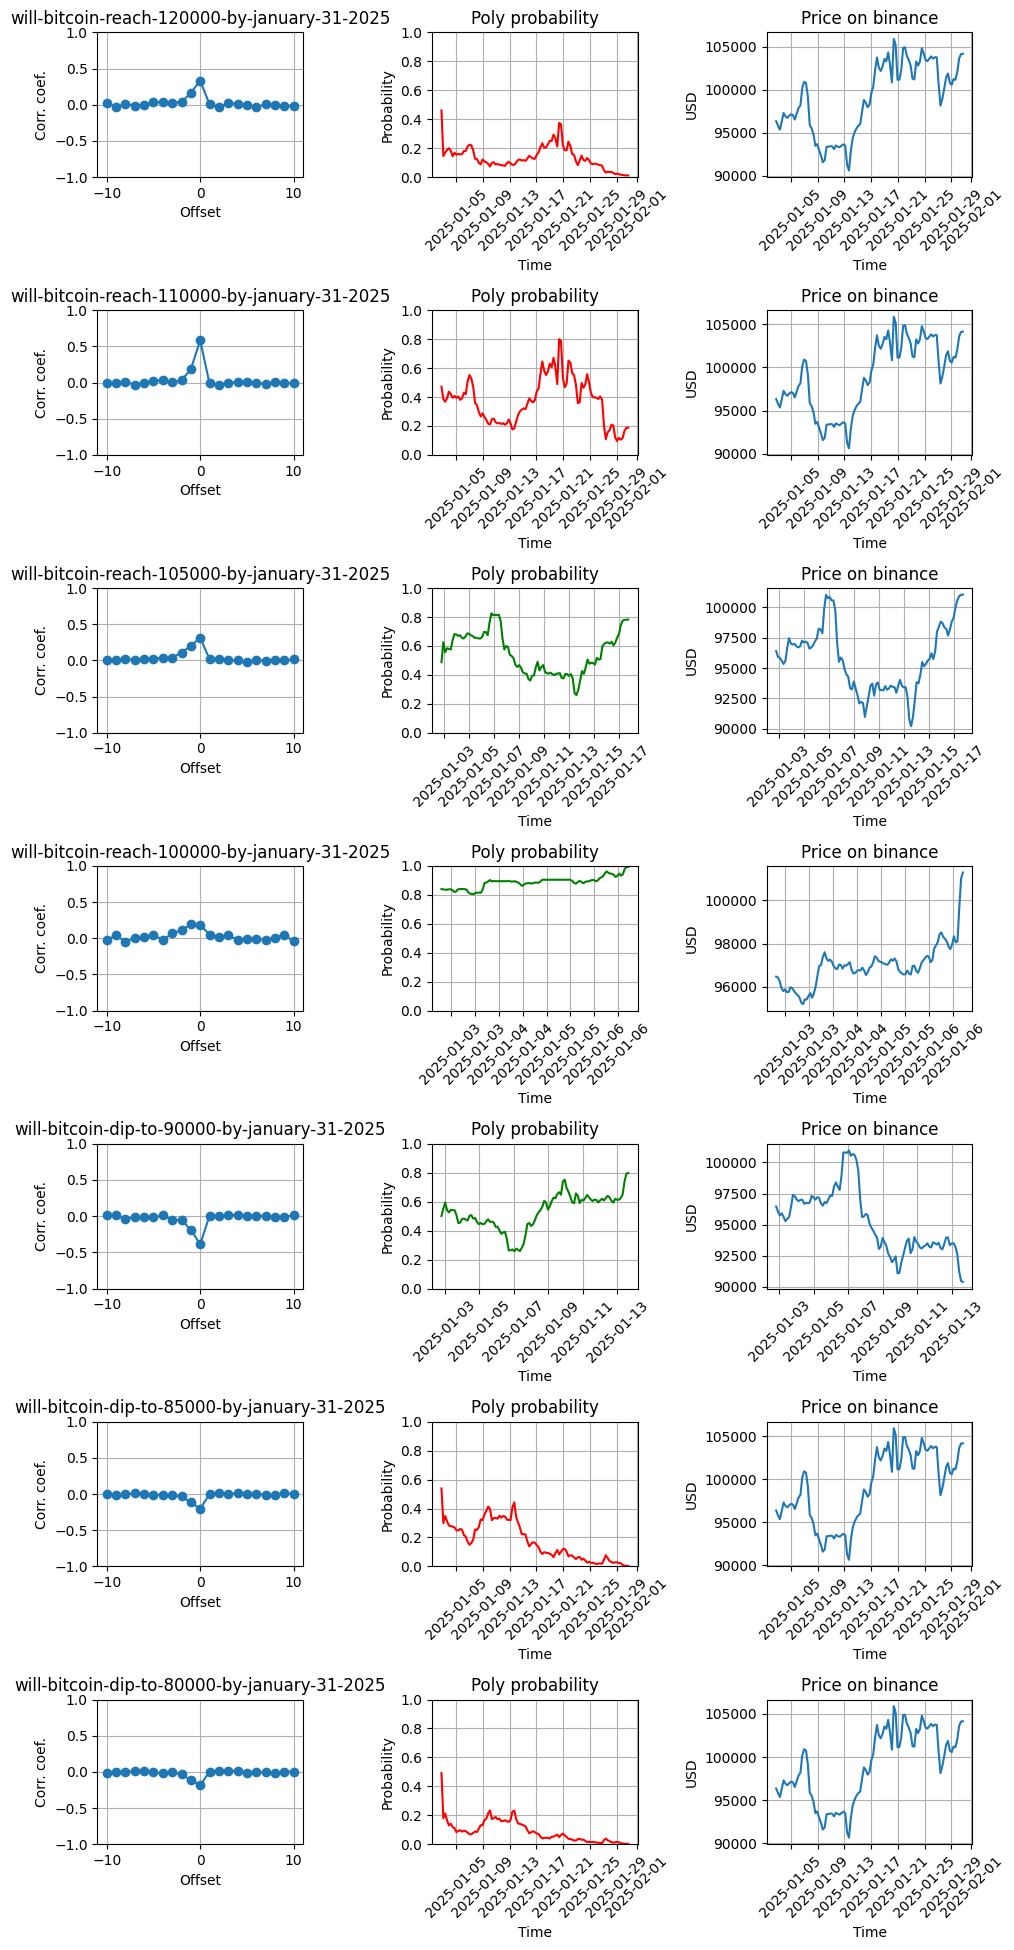

In [44]:
# importlib.reload(analysis)

ts_options = poly_api.TSOptions(
    fidelity_in_minutes=3,
    interval_to_load=(
        datetime.fromisoformat("2025-01-02 19:00"),  # Market start date
        datetime.fromisoformat("2025-01-30 23:00"),  # Market end date
    ),
)
corr_offset_amplitude = 10
raw_markets = poly_api.load_markets_data(market_ids, ts_options)
processed_markets = poly_datasets.process_pm_df(raw_markets)


analyze_poly_markets(
    processed_markets,
    ts_options.fidelity_in_minutes,
    corr_offset_amplitude,
    strip_percent=None,
    min_corr_threshold=0.1,
)

### Correlations plot interpretation



Each row represents a market, a slug of which is written on the plot's left side.

There are 3 columns per row:
1. Correlation coef. on y axis after applying an offset shown on x axis.
2. Polymarket probability over time.
3. Binance BTC price over time.



At offset 0, there is a notable positive correlation on bets that BTC will grow, and notable negative correlation that BTC will loose in its price, which can indicate that most of the market reponds to BTC's price change reactively.

An offset indicates how were polymarket probabilites shifted. 1 offset equates to 3 minutes shift. I'm yet unable to get data with a 1 minute interval between datapoints.
- When correlation is positive -> Polymarket changes ahead of BTC price.
- When correlation is negative -> Polymarket changes after BTC changes.
- When correlation is zero -> They change at a similar time interval.



Some markets were omitted because there wasn't any notably high correlation with a given offset amplitude. 

3 plots of the same market are shown. They have varying intervals between datapoints: 60min, 15min, 3min.

As can be seen there is a string correlation at offset 0, near 0 correlation on most offsets > 0, and some correlation at offsets < 0. **It means that poly probability & BTC prices move in the same (or opposite) directions at a 60/30/3 min datapoint intervals.**

Also, at 3 min intervals there is a visibile correlation at offsets -1 and -2, albeit much weaker. **It could indicate that poly probability change is to some extent influenced by BTC price change with ~0-9min delay.**

Another observation one can make is that the less market is confident in its own prediction (poly probability is mostly between 0.3 and 0.7), the higher the correlations, which indicates that **when market is unsure, they tend to be much more reactive.**

Upd: This correlation seems to be caused by noise traders.


### More markets

#### Market: bitcoin-price-on-march-14

In [45]:
from matplotlib import pyplot as plt
import mplfinance as mpf

# importlib.reload(binance_datasets)

# https://polymarket.com/event/bitcoin-price-on-march-14?tid=1742032413563
market_ids2 = "0xd9fc380bb3c5c06e3b332d7a5d3051ee0b74d3e51dc9676c5bb6b5055ce92f6d,0xea348e8bfe03af4a195286ffe25f0f733c2d54fe50f9d54835e6775f6613aa9a,0x4e720ef02e20df66202c30f53d4d1b233ebe4fd6da023b2468026f4f29102ac1,0x64565382a32c6f61639e1fdb33ba6f93115511c027882acedc7414c402a9cb8f,0x2f9f585b5f816394fc36677d676ab643cb7b05b6db31a0bdb7e6338fc33c93ca,0xe85f139d7a784177f3861d3e650b6031a45ff16454a513ba212a3ac19b44e426,0x80bfbfba1a642809b7dadc738f960b3ca19fef3b0c0f6b8f00670b268f6416f3".split(
    ","
)

ts_options = poly_api.TSOptions(
    fidelity_in_minutes=60,
    interval_to_load=(
        datetime.fromisoformat("2025-03-07 18:00"),
        datetime.fromisoformat("2025-03-14 21:00"),
    ),
)
corr_offset_amplitude = 6
raw_markets = poly_api.load_markets_data(market_ids2, ts_options)
processed_markets = poly_datasets.process_pm_df(raw_markets)


Loading from binance at intervals: from 2025-03-07 18:00:00 until 2025-03-14 19:00:00


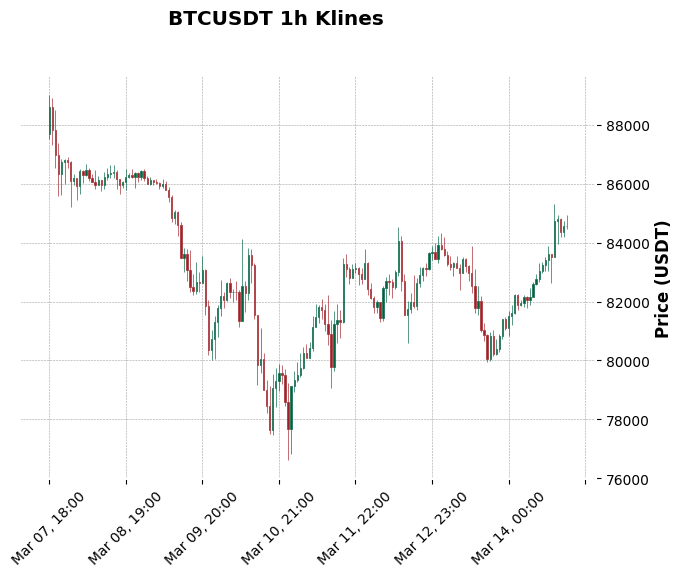

In [46]:

btc_klines = binance_datasets.load_matching_binance_data(processed_markets, ts_options.fidelity_in_minutes)

# Save original settings. mpf changes them globally, which I don't want to happen.
original_params = dict(plt.rcParams)

mpf.plot(
    btc_klines,
    type="candle",
    style="charles",
    title="BTCUSDT 1h Klines",
    ylabel="Price (USDT)",
)

# Restore original settings
plt.rcParams.update(original_params)

Analyzing 7 markets
Loading from binance at intervals: from 2025-03-07 18:00:00 until 2025-03-14 19:00:00
Plotting 7 markets


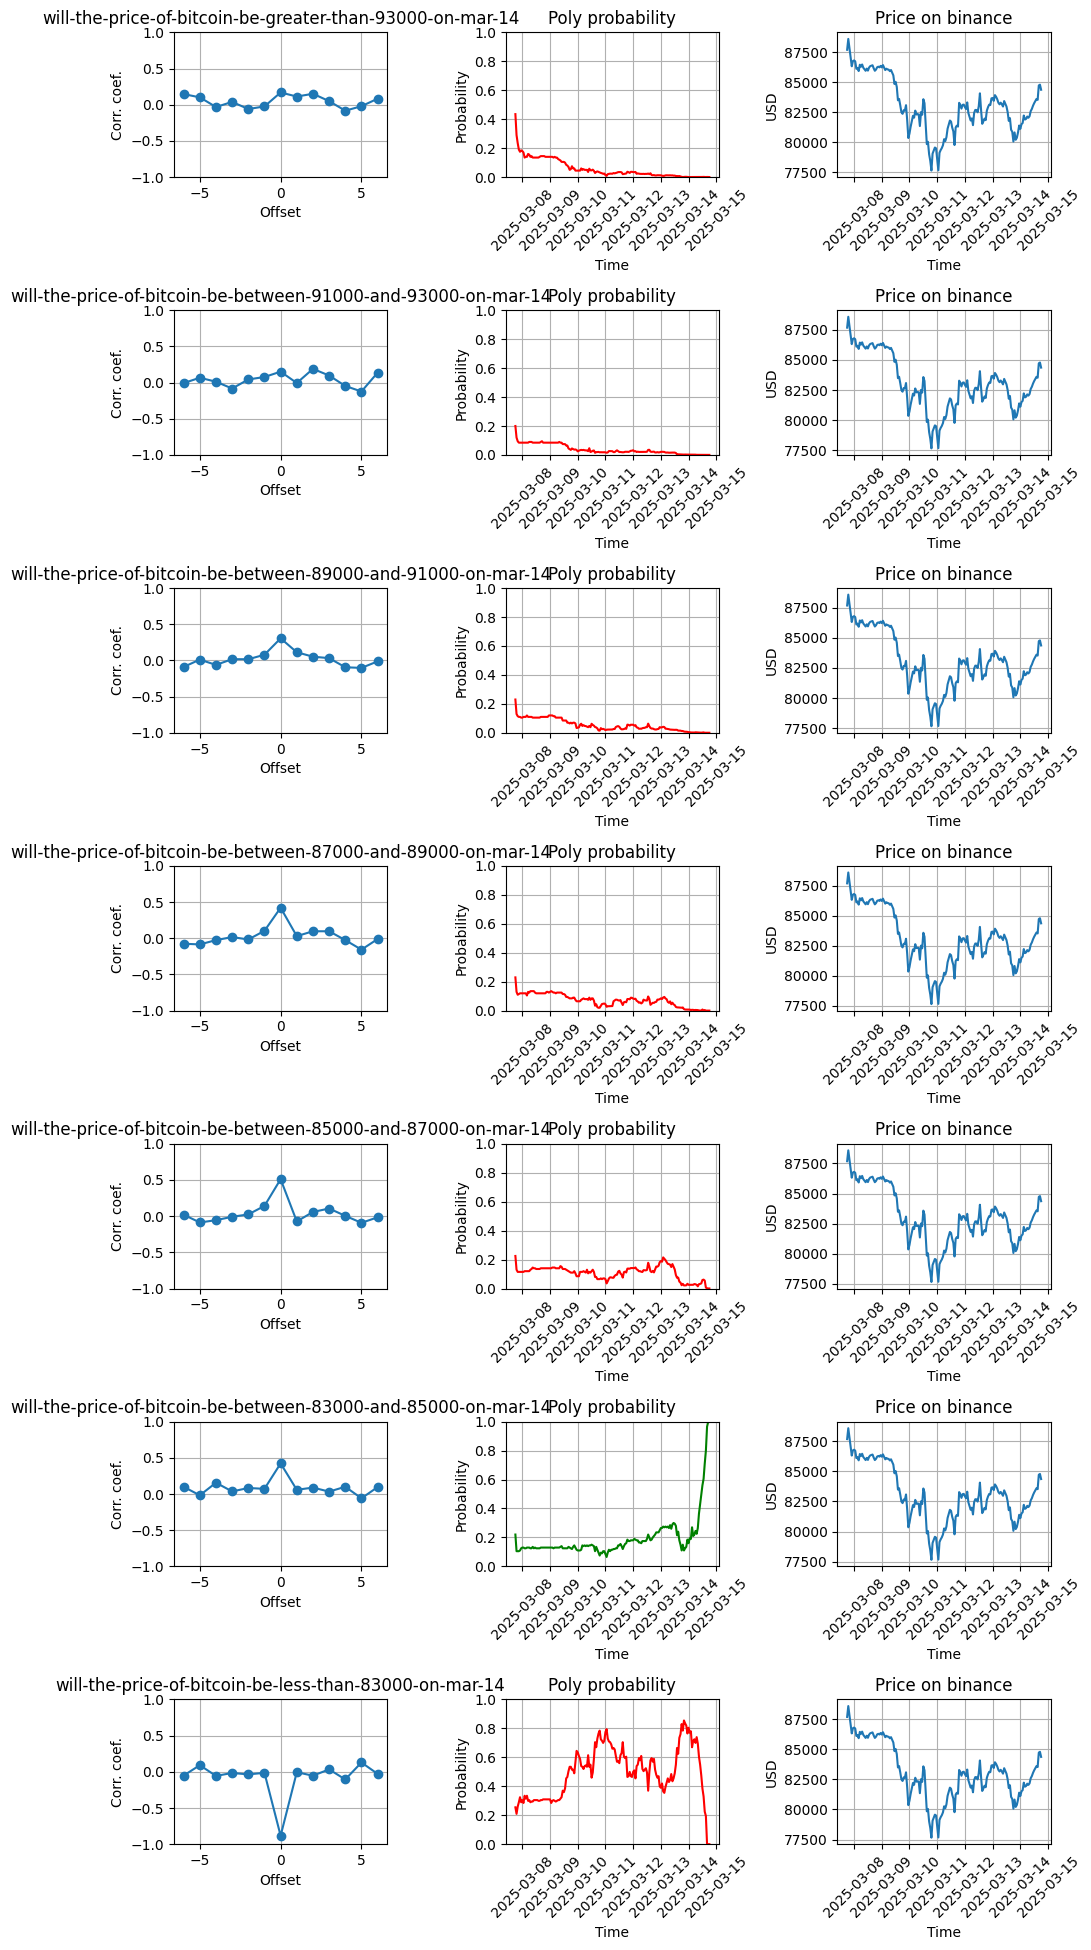

In [47]:

analyze_poly_markets(
    processed_markets,
    ts_options.fidelity_in_minutes,
    corr_offset_amplitude,
    strip_percent=None,
    min_corr_threshold=0,
)


Analyzing 7 markets
Loading from binance at intervals: from 2025-03-07 17:30:00 until 2025-03-14 19:45:00
Skipping `will-the-price-of-bitcoin-be-between-83000-and-85000-on-mar-14` due to low correlation (corr < 0.1)
Plotting 6 markets


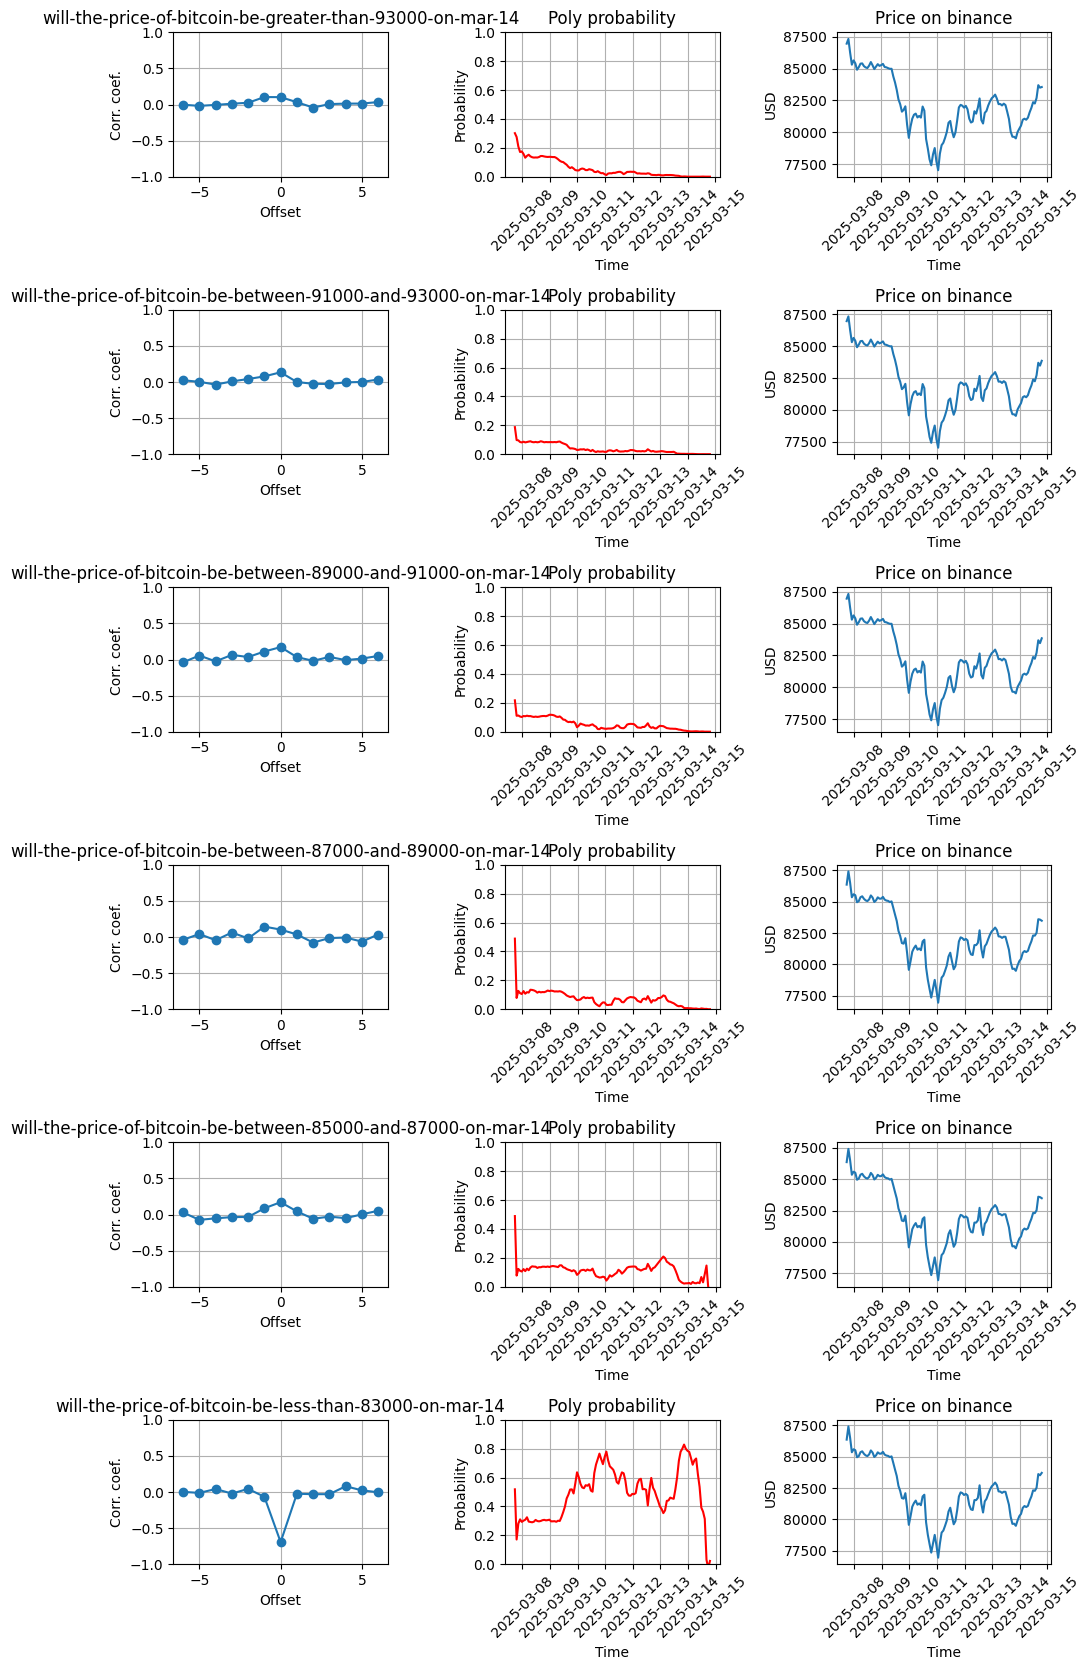

In [56]:

ts_options = poly_api.TSOptions(
    fidelity_in_minutes=15,
    interval_to_load=(
        datetime.fromisoformat("2025-03-07 18:00"),
        datetime.fromisoformat("2025-03-14 21:00"),
    ),
)
corr_offset_amplitude = 6
raw_markets = poly_api.load_markets_data(market_ids2, ts_options)
processed_markets = poly_datasets.process_pm_df(raw_markets)

analyze_poly_markets(
    processed_markets,
    ts_options.fidelity_in_minutes,
    corr_offset_amplitude,
    strip_percent=None,
    min_corr_threshold=0.1,
)

#### Market: bitcoin-price-on-march-7

Analyzing 7 markets
Loading from binance at intervals: from 2025-02-28 19:00:00 until 2025-03-07 20:00:00
Plotting 7 markets


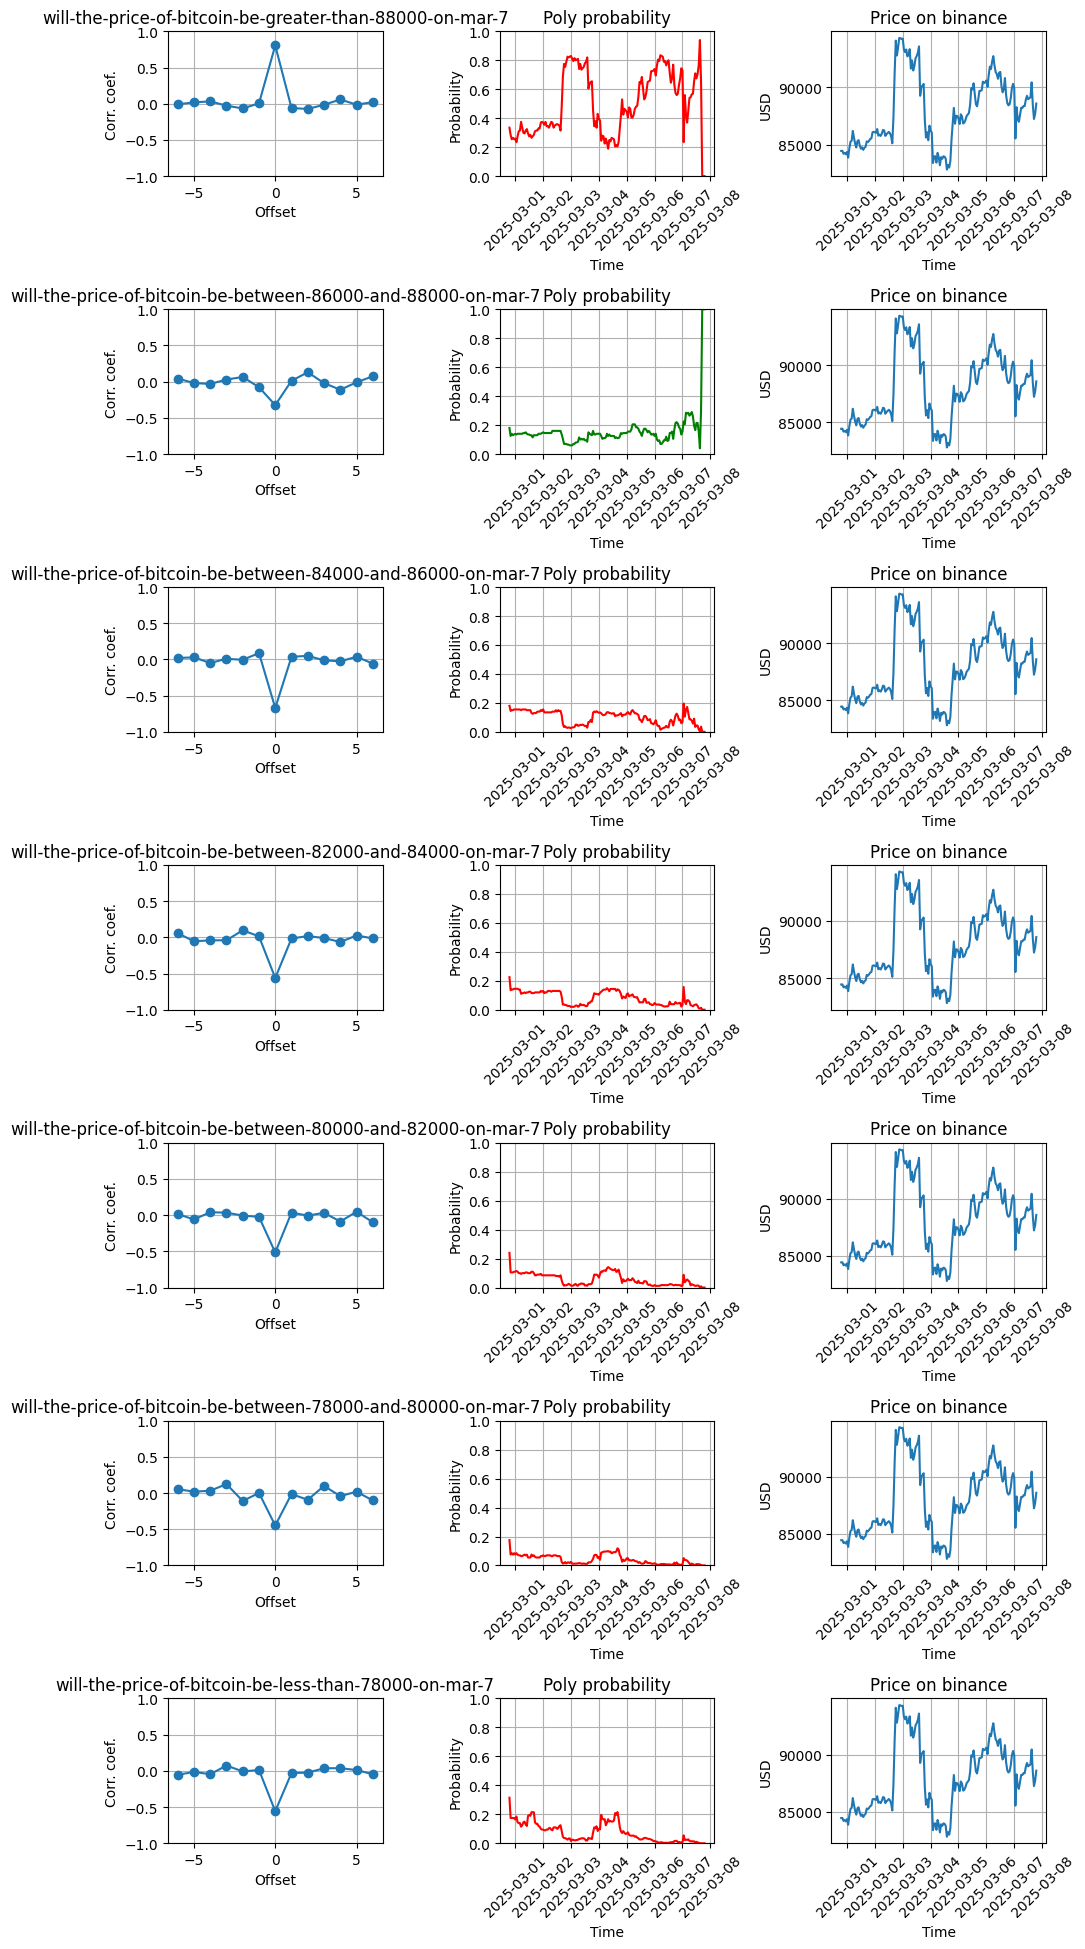

In [49]:
# https://polymarket.com/event/bitcoin-price-on-march-7?tid=1742037572763
market_ids3 = [
    "0x845afc0daac64d1d5d955e39b3c4763c271b90c13d84593479b9fbe7b794030b",
    "0x7ce43fde974369950c4c8c1c37649f6ce0f8e7017153f15ba71f32ebb2ac4595",
    "0x9aa80760a847e9a85dada5010081ffcd8b597d9b1578a07707b7dcf7b53a9ebd",
    "0xf31c8ef606ed3dbf4ba7fca3ca59d7acba59aa8326a94b57a02d35ef0dc58521",
    "0x16a61d52c743f876b6abc7ffa6baa94ad27f0eeaa01412c89b8dab8ddd519665",
    "0xaf2cef753e5f289fbd9c912c6026f14d46dcacdc7773bf3521b0edb08d8c727f",
    "0xbb0224941da5cce71e72eab569f6b71cb6e3a6ac9e6da1f784c5e5cffdf29757",
]

ts_options = poly_api.TSOptions(
    fidelity_in_minutes=60,
    interval_to_load=(
        datetime.fromisoformat("2025-02-28 19:00"),
        datetime.fromisoformat("2025-03-07 22:00"),
    ),
)
corr_offset_amplitude = 6
raw_markets = poly_api.load_markets_data(market_ids3, ts_options)
processed_markets = poly_datasets.process_pm_df(raw_markets)

analyze_poly_markets(
    processed_markets,
    ts_options.fidelity_in_minutes,
    corr_offset_amplitude,
    strip_percent=None,
    min_corr_threshold=0.1,
)


Analyzing 7 markets
Loading from binance at intervals: from 2025-02-28 18:15:00 until 2025-03-07 20:30:00
Plotting 7 markets


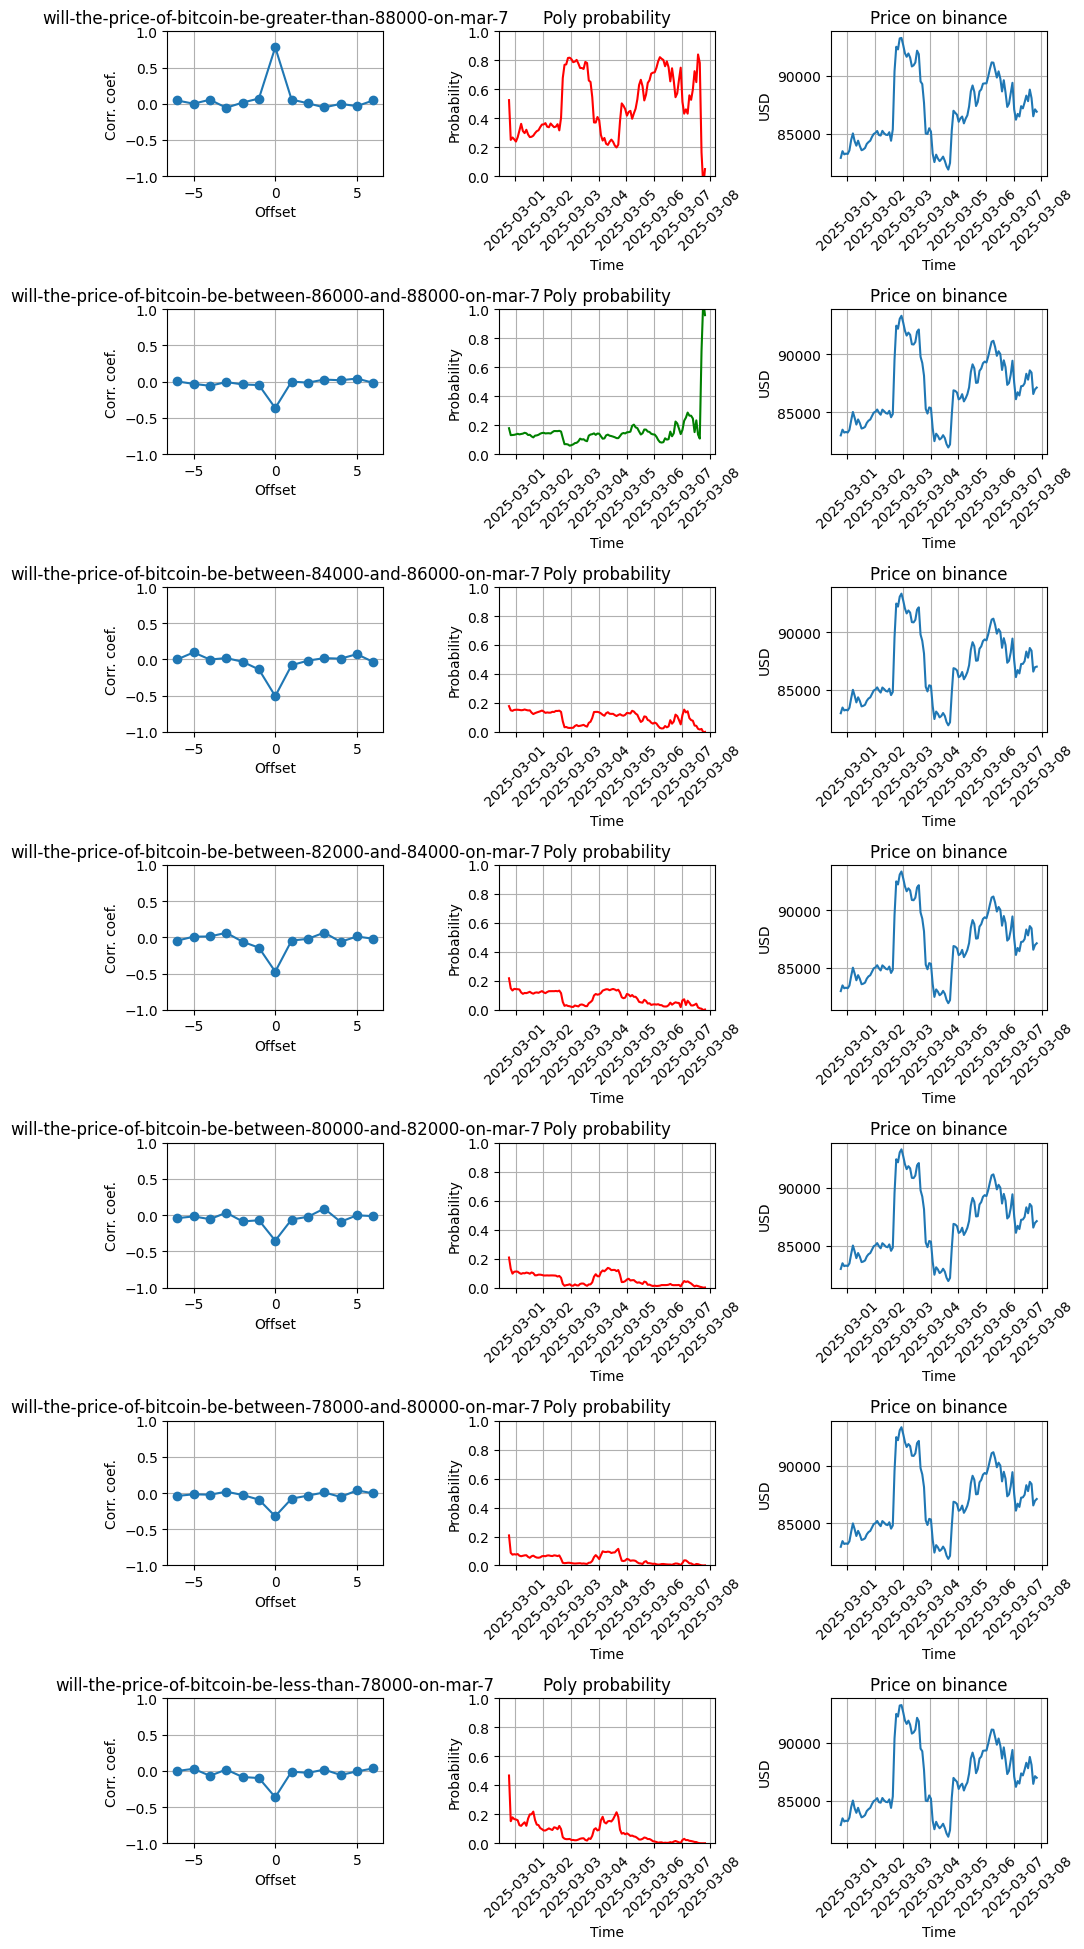

In [50]:

ts_options = poly_api.TSOptions(
    fidelity_in_minutes=15,
    interval_to_load=(
        datetime.fromisoformat("2025-02-28 19:00"),
        datetime.fromisoformat("2025-03-07 22:00"),
    ),
)
corr_offset_amplitude = 6
raw_markets = poly_api.load_markets_data(market_ids3, ts_options)
processed_markets = poly_datasets.process_pm_df(raw_markets)

analyze_poly_markets(
    processed_markets,
    ts_options.fidelity_in_minutes,
    corr_offset_amplitude,
    strip_percent=None,
    min_corr_threshold=0.1,
)


Analyzing 7 markets
Loading from binance at intervals: from 2025-02-28 18:09:00 until 2025-03-07 20:33:00
Plotting 7 markets


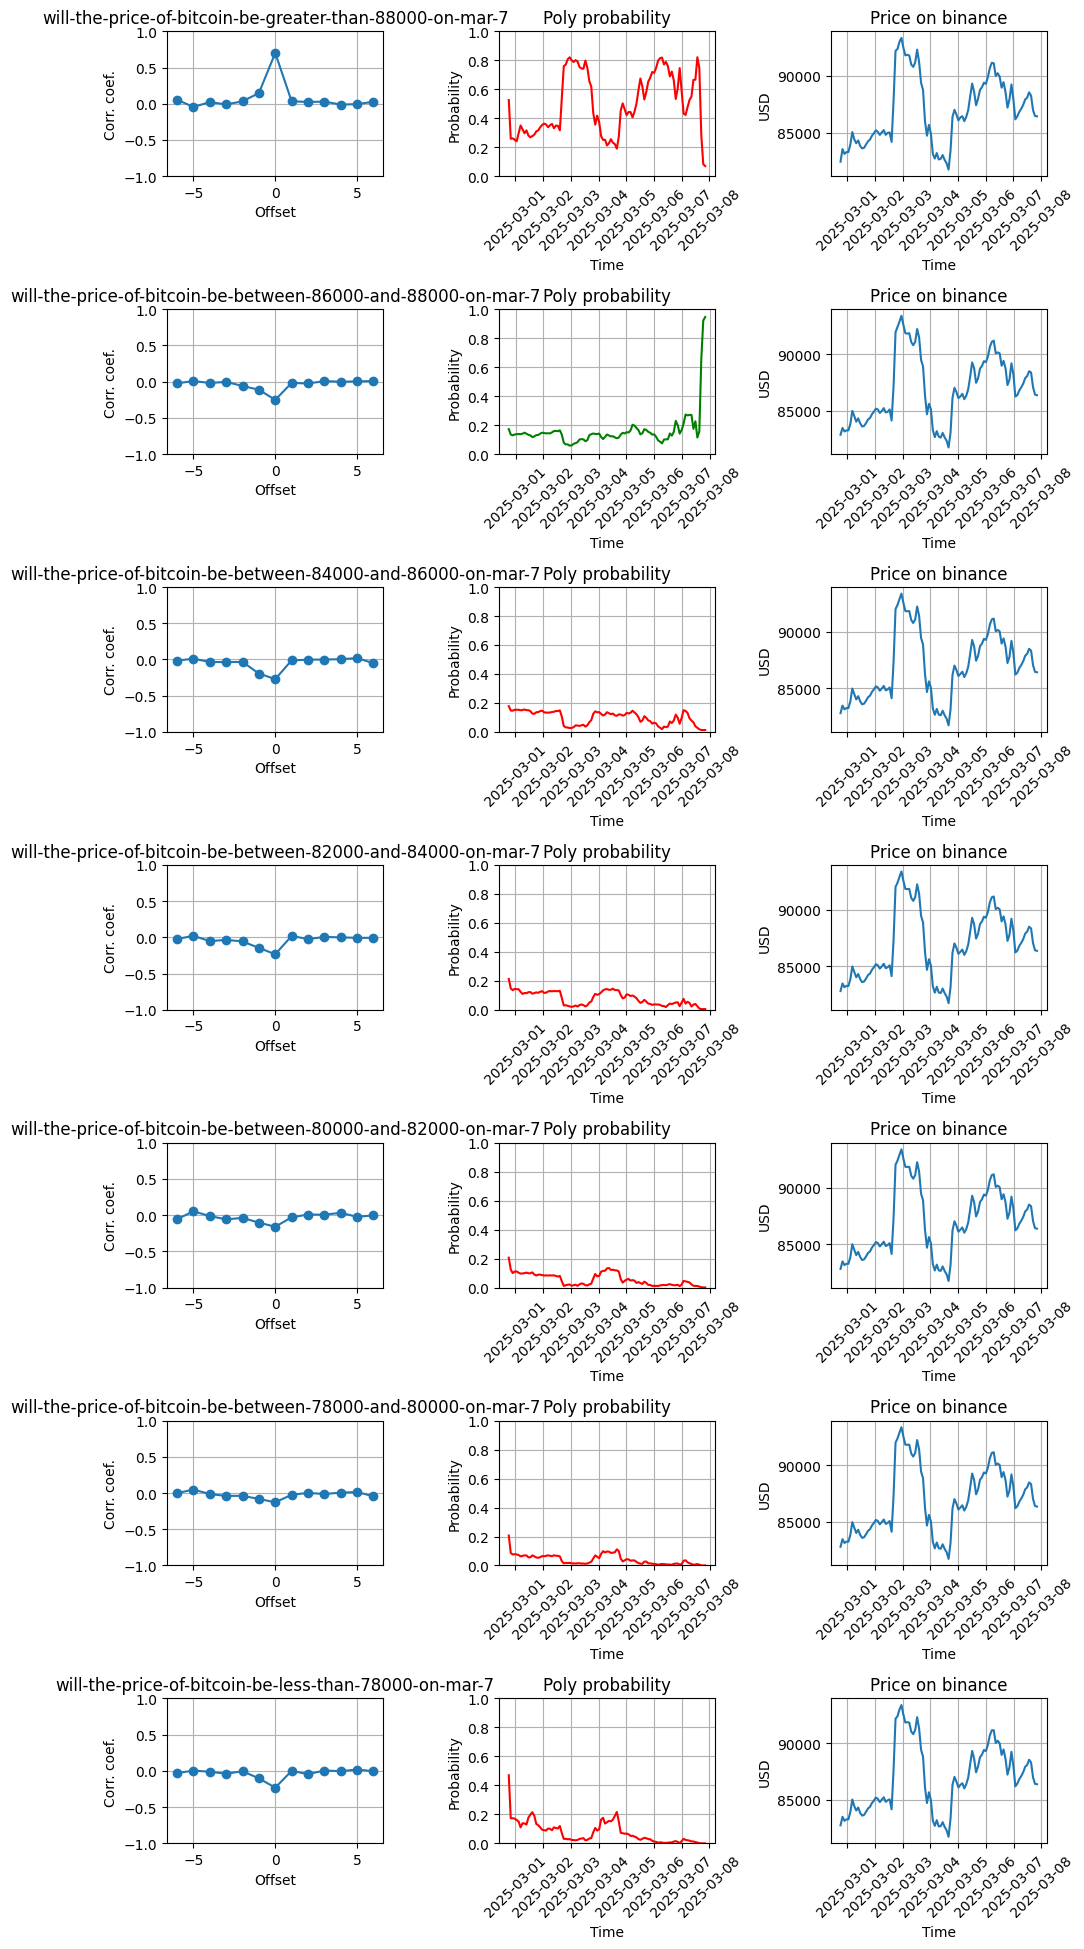

In [ ]:

ts_options = poly_api.TSOptions(
    fidelity_in_minutes=3,
    interval_to_load=(
        datetime.fromisoformat("2025-02-28 19:00"),
        datetime.fromisoformat("2025-03-07 22:00"),
    ),
)
corr_offset_amplitude = 6
raw_markets = poly_api.load_markets_data(market_ids3, ts_options)
processed_markets = poly_datasets.process_pm_df(raw_markets)

analyze_poly_markets(
    processed_markets,
    ts_options.fidelity_in_minutes,
    corr_offset_amplitude,
    strip_percent=None,
    min_corr_threshold=0.1,
)


#### Interpretation

In these plots, markets that span 1 week were shown.

They seem to have higher correlations on less confident (probability changes drastically over time) markets